#### Multi-Agent Reactive Planning

In [1]:
import sys
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import autograd
from torch.utils.data import DataLoader
from torch.nn.parameter import Parameter
import torch.nn.functional as F

In [2]:
import random
import queue

#### Import the Dataset

In [3]:
train = []
with np.load('dataset/Train_data/train_4_data.npz',mmap_mode='r') as f:
    train = f['arr_0']

In [4]:
test = []
with np.load('dataset/Test_dat/test_4_data.npz',mmap_mode='r') as f:
    test = f['arr_0']

In [5]:
train_data = []
for i in train:
    env = -1*(i[0] == 0.0) + 1.0
    goal = (i[0] == 0.5) + 0.0
    agent = (i[1] == 1.0) * -1
    agent[i[2][0]][i[2][1]] = 0.0
    env = env + agent
    agent[i[2][0]][i[2][1]] = 1.0
    
    domain = np.array([env,goal,agent])
    
    
    train_data.append([torch.tensor(domain),torch.tensor(i[2]),torch.tensor(i[3])])

In [6]:
test_data = []
for i in test:
    env = -1*(i[0] == 0.0) + 1.0
    goal = (i[0] == 0.5) + 0.0
    agent = (i[1] == 1.0) * -1
    agent[i[2][0]][i[2][1]] = 0.0
    env = env + agent
    agent[i[2][0]][i[2][1]] = 1.0
    
    domain = np.array([env,goal,agent])
    
    
    test_data.append([torch.tensor(domain),torch.tensor(i[2]),torch.tensor(i[3])])

In [7]:
train_dl = DataLoader(train_data,batch_size=128,shuffle=False)
test_dl = DataLoader(test_data,batch_size=128,shuffle=False)

#### Model

In [8]:
class MA_PR(torch.nn.Module):
    def __init__(self):
        super(MA_PR, self).__init__()
        
        self.l1 = torch.nn.Conv2d(
            in_channels=3,
            out_channels=10,
            kernel_size=(3, 3),
            stride=1,
            padding=1,
            bias=True)
        
        self.l2 = torch.nn.Conv2d(
            in_channels=10,
            out_channels=20,
            kernel_size=(3, 3),
            stride=1,
            padding=1,
            bias=True)
        
        self.l3 = torch.nn.MaxPool2d(2,2)
        
        self.l4 = torch.nn.Conv2d(
            in_channels=20,
            out_channels=40,
            kernel_size=(3, 3),
            stride=1,
            padding=1,
            bias=True)
        self.l5 = torch.nn.Conv2d(
            in_channels=40,
            out_channels=80,
            kernel_size=(3, 3),
            stride=1,
            padding=1,
            bias=True)
        
        self.l6 = torch.nn.MaxPool2d(2,2)
        
        self.fc1 = torch.nn.Linear(320,320)
        
        self.fc2 = torch.nn.Linear(320,120)
        
        self.fc3 = torch.nn.Linear(120,60)
        
        self.fc4 = torch.nn.Linear(60,30)
        
        self.fc5 = torch.nn.Linear(30,5)
        
        self.sm = torch.nn.Softmax(dim=1)

    def forward(self, X, S1, S2):
        
        X = F.relu(self.l1(X))
        X = F.relu(self.l2(X))
        
        X = self.l3(X)
        
        X = F.relu(self.l4(X))
        X = F.relu(self.l5(X))
        
        X = self.l6(X)
        
        X = X.view(-1,320)
        
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = F.relu(self.fc3(X))
        X = F.relu(self.fc4(X))
        
        logits = self.fc5(X)
       
        return logits, self.sm(logits)

In [9]:
model = MA_PR()

In [10]:
model.load_state_dict(torch.load('./trained/MA_PR_8x8.pth',map_location='cpu'))

#### Loss

In [11]:
Criterion = torch.nn.CrossEntropyLoss()

#### Optimizer

In [12]:
optimizer = torch.optim.RMSprop(model.parameters(),lr=0.001)

#### Training

In [15]:
N_Epoch = 1

for i in range(N_Epoch):
    running_loss = 0.0
    correct = 0
    
    model.eval()
    
    train_iter = iter(train_dl)
    
    for j in range(326):
    
        X,S,label = next(train_iter)
        
        
        output, prediction = model(X.float(),S[:,0],S[:,1])
        
        loss = Criterion(output,label)
        
        running_loss += loss.item()
        
        _,index = torch.max(output,dim=1)
        
        correct += torch.eq(index, label).sum().item()
    
    print(f"Epoch:{i}")
    print(f'Average_loss :{running_loss / 326}')
    print(f"Accuracy : {correct / len(train_data)}")

Epoch:0
Average_loss :0.024226067512027598
Accuracy : 0.9940451893293635


#### Testing

In [19]:
N_Epoch = 1

for i in range(N_Epoch):
    running_loss = 0.0
    correct = 0
    
    model.eval()
    
    test_iter = iter(test_dl)
    
    for j in range(147):
    
        X,S,label = next(test_iter)
        
        
        output, prediction = model(X.float(),S[:,0],S[:,1])
        
        loss = Criterion(output,label)
        
        running_loss += loss.item()
        
        _,index = torch.max(output,dim=1)
        
        correct += torch.eq(index, label).sum().item()
    
    print(f"Epoch:{i}")
    print(f'Average_loss :{running_loss / 147}')
    print(f"Accuracy : {correct / len(test_data)}")

Epoch:0
Average_loss :4.49163005789932
Accuracy : 0.7019482252468642


#### Check the goal accuracy for 8x8 data

In [20]:
def action(S,val,obst,imsize):
    if val == 0 and S[1].item() > 0:
        if obst[S[0].item()][S[1].item()-1] == 1.0 :
            return torch.tensor([S[0].item(),S[1].item()-1]), False
        else :
            return torch.tensor([S[0].item(),S[1].item()]), True
    elif val == 1 and S[0].item() > 0:
        if obst[S[0].item()-1][S[1].item()] == 1.0 :
            return torch.tensor([S[0].item()-1,S[1].item()]), False
        else :
            return torch.tensor([S[0].item(),S[1].item()]), True
    elif val == 2 and S[1].item() < (imsize -1):
        if obst[S[0].item()][S[1].item()+1] == 1.0 :
            return torch.tensor([S[0].item(),S[1].item()+1]), False
        else:
            return torch.tensor([S[0].item(),S[1].item()]), True
    elif val == 3 and S[0].item() < (imsize -1):
        if obst[S[0].item()+1][S[1].item()] == 1.0 :
            return torch.tensor([S[0].item()+1,S[1].item()]), False
        else:
            return torch.tensor([S[0].item(),S[1].item()]), True
    else :
        return S, True

In [21]:
def rand_play(X,a_s,imsize,obst):
    #find possible action
    Action = []
    
    if (a_s[1] -1) >= 0:
        if X[0][a_s[0]][a_s[1]-1] and (not X[2][a_s[0]][a_s[1]-1]):
            Action.append(0)
    if (a_s[0] -1 ) >= 0:
        if X[0][a_s[0]-1][a_s[1]] and (not X[2][a_s[0]-1][a_s[1]]):
            Action.append(1)
    if (a_s[1] +1 ) < imsize:
        if X[0][a_s[0]][a_s[1]+1] and (not X[2][a_s[0]][a_s[1]+1]):
            Action.append(2)
    if (a_s[0] + 1) < imsize:    
        if X[0][a_s[0]+1][a_s[1]] and (not X[2][a_s[0]+1][a_s[1]]):
            Action.append(3)
    
    if len(Action) != 0:
        act = np.random.choice(Action)
        new_state,_ = action(a_s,act,obst,imsize)
    else:
        new_state = a_s
    
    return new_state

In [22]:
def goal_reach_check(agent_state,goal,goal_count,goal_reached):
    token = 0
    v = 0
    for z in goal:
        #check goal is already reached
        if goal_reached[v] == 0:
            #if goal is not reached and compare with agent state
            if agent_state[0].item() == z[0] and agent_state[1].item() == z[1]:
                goal_reached[v] = 1
                goal_count += 1
                token = 1
        v = v+1    
    return token,goal_count,goal_reached

In [23]:
def agent_env(X,agent_state,imsize,avoid_goal,token):
   
    return X.reshape([1,3,imsize,imsize]).float()

In [42]:
def agent_prediction(model,X,whole_traj_act,goal,imsize,max_random_play):
    #convert specific domain to generic domains
    X = abs(X)
    
    model.eval() 
    correct_goal,total_goal,traj_step_error,goal_count = 0.0,0.0,0.0,0.0
    
    #store agent initial state
    inter = np.where(X[2] == 1.0)
    agent_state = np.column_stack([inter[0],inter[1]])
    n_agent = agent_state.shape[0]
    
    agent_traj = [[agent_state[i].copy()] for i in range(n_agent)]
    
    #store number agent still playing
    current_play_agent = [1.0 for i in range(n_agent)]
    
    current_play_agent = np.array(current_play_agent)
    
    #keep which is reached
    goal_reached = np.zeros([goal.size])
    
    #store each agent random play chances
    random_play = np.zeros(n_agent)
    max_random_play = max_random_play
    
    play = 0
    while current_play_agent.sum() != 0.0 and play < 20:
        play += 1
        for i in range(n_agent):
            
            if current_play_agent[i] == 1.0:  
                Input = agent_env(X.clone(),agent_state[i],imsize,[],1)
                output,prediction= model(Input,torch.tensor(agent_state[i][0]),torch.tensor(agent_state[i][1]))
                _,index = torch.max(output,dim=1)
              #  print(agent_state[i],index)
                #check agent (index = 4) means stop planning
                if index == 4:
                    #token whether agent reach goal or not
                    token,goal_count,goal_reached = goal_reach_check(agent_state[i],goal,goal_count,goal_reached)
                    if token:
                        current_play_agent[i] = 0.0
                    else:
                        if random_play[i] >= max_random_play:
                            current_play_agent[i] = 0.0
                        else:
                            X[2][agent_state[i][0]][agent_state[i][1]] = 0.0
                            agent_state[i] =rand_play(X,agent_state[i].copy(),imsize)
                            random_play[i] += 1
                            X[2][agent_state[i][0]][agent_state[i][1]] = 1.0
                            agent_traj[i].append(agent_state[i].copy())
    
                else:
                    
                    agent_new_state,obst = action(S=agent_state[i],val=index,imsize=imsize,obst=Input[0,0,:,:])
                    
                    if obst:
                        current_play_agent[i] = 0.0
                    #    print(1)
                        continue
                    X[2][agent_state[i][0]][agent_state[i][1]] = 0.0
                    agent_state[i] = agent_new_state
                    #check agent reach any obstacle and push it into stop
                    i_1 = agent_state[i][0]
                    i_2 = agent_state[i][1]
                    if X[0][i_1][i_2].item() == 0.0 and X[1][i_1][i_2].item() == 0.0:
                        print(2)
                        current_play_agent[i] = 0.0
                        
                    X[2][agent_state[i][0]][agent_state[i][1]] = 1.0
                    agent_traj[i].append(agent_state[i].copy())
                    
                    #stop agent which moves back and forward two on the goal
                    if len(agent_traj[i]) > 3 and (agent_traj[i][-1] == agent_traj[i][-3]).sum() == 2 and (agent_traj[i][-2] == agent_traj[i][-4]).sum() == 2:
                        
                        inter = agent_traj[i][-1]
                        token,goal_count,goal_reached = goal_reach_check(inter,goal,goal_count,goal_reached)
                        if token:
                           # print(3)
                            current_play_agent[i] = 0.0
                        else:     
                            inter = agent_traj[i][-2]
                            token,goal_count,goal_reached = goal_reach_check(inter,goal,goal_count,goal_reached)
                            if token:
                              #  print(4)
                                current_play_agent[i] = 0.0
                                agent_traj[i].pop(-1)
                            else:
                                if random_play[i] < max_random_play:
                                    X[2][agent_state[i][0]][agent_state[i][1]] = 0.0
                                    
                                    agent_state[i] =rand_play(X,agent_state[i].copy(),imsize)
                                    random_play[i] += 1
                                    X[2][agent_state[i][0]][agent_state[i][1]] = 1.0
                                    agent_traj[i].append(agent_state[i].copy())
                                else:
                                  #  print(5)
                                    current_play_agent[i] = 0.0
                    
    for j in range(len(whole_traj_act)):
        inter =  whole_traj_act[j][0][0].numpy() 
        for i in range(len(agent_traj)):
            if inter[0] == agent_traj[i][0][0] and inter[1] == agent_traj[i][0][1]:
                actual_len = len(agent_traj[i])
                pred_len = len(whole_traj_act[j][0])
                traj_step_error += (abs(pred_len - actual_len))
    
    
    correct_goal = goal_count
    
    if n_agent > len(goal):
        total_goal = len(goal)
    else:
        total_goal =  n_agent
        
    traj_step = -1000
    for i in agent_traj:
        if len(i) > traj_step:
            traj_step = len(i)
    
    return correct_goal,total_goal,(traj_step),agent_traj

In [43]:
def visualization(dom,whole_traj_act,traj):
    fig, ax = plt.subplots()
    implot = plt.imshow(dom, cmap="Greys_r")

    opti = []
    for i in whole_traj_act:
        opti.append(i[0])

    for i in opti:
        opti_arr =  []
        for j in i:
            opti_arr.append([j[0].item(),j[1].item()])

        opti_ar = np.array(opti_arr)
        ax.plot(opti_ar[:,1], opti_ar[:,0], c='b')

    start = []
    for i in traj:
        start.append(i[0])

    #start = np.array(start)
    for i in start:
        ax.plot(i[1], i[0], '-s')

    start = []
    for i in traj:
        path = []
        for j in i:
            path.append(j)

        path = np.array(path)
        ax.plot(path[:, 1], path[:, 0], '-X', c='r')

 #   for i in goal:
 #       ax.plot(i[1], i[0], '-s')
    legend = ax.legend(loc='upper right', shadow=False)
#    for label in legend.get_texts():
#        label.set_fontsize('x-small')  # the legend text size
#    for label in legend.get_lines():
#        label.set_linewidth(0.5)  # the legend line width
    plt.draw()
    plt.show()

#### Training Goal accuracy

In [46]:
correct, traj_step, total,total_env = 0.0,0.0,0.0,0.0

X,S,label = train_data[0].copy()

prev_env = X.clone()

whole_traj_act = []

Trajectory = [S]
Action  = [label]

go = np.where(X[1] == 1.0) 
goal = np.column_stack([go[0],go[1]])

end = len(train_data)


for i in range(1,end):
    X,S,label = train_data[i].copy()
    
    new_env = X.clone()
    
   
    if (new_env[0] - prev_env[0]).sum() == 0.0:

        if label != 4:
            Trajectory.append(S)
            Action.append(label)
        else:
            Trajectory.append(S)
            Action.append(label)
            whole_traj_act.append([Trajectory,Action])
            Trajectory = []
            Action = []
    else :
        #call the function with prev_new and whole traj act
        total_env += 1
        correct_goal,total_goal, traj_length,traj = agent_prediction(model,prev_env.clone(),whole_traj_act,goal,8,0)
        
        

        total += total_goal

        correct += correct_goal
        traj_step += traj_length
        
        prev_env = new_env.clone()
        
        
        whole_traj_act = []
        go = np.where(prev_env[1] == 1.0) 
        goal = np.column_stack([go[0],go[1]])
        
        
print(f'Goal_accuray: {correct /total}')
print(correct,total)
print(f'Average_Step_error_in_each_domain : {traj_step/total_env}')
print(traj_step,total_env)

Goal_accuray: 0.3198496240601504
2127.0 6650.0
Average_Step_error_in_each_domain : 5.2246575342465755
19070.0 3650.0


#### Testing goal accuracy

In [48]:
correct, traj_step, total,total_env = 0.0,0.0,0.0,0.0

X,S,label = test_data[0].copy()

prev_env = X.clone()

whole_traj_act = []

Trajectory = [S]
Action  = [label]

go = np.where(X[1] == 1.0) 
goal = np.column_stack([go[0],go[1]])

end = len(test_data)


for i in range(1,end):
    X,S,label = test_data[i].copy()
    
    new_env = X.clone()
    
   
    if (new_env[0] - prev_env[0]).sum() == 0.0:

        if label != 4:
            Trajectory.append(S)
            Action.append(label)
        else:
            Trajectory.append(S)
            Action.append(label)
            whole_traj_act.append([Trajectory,Action])
            Trajectory = []
            Action = []
    else :
        #call the function with prev_new and whole traj act
        total_env += 1
        correct_goal,total_goal, traj_length,traj = agent_prediction(model,prev_env.clone(),whole_traj_act,goal,8,0)
        
        

        total += total_goal

        correct += correct_goal
        traj_step += traj_length
        
        prev_env = new_env.clone()
        
        
        whole_traj_act = []
        go = np.where(prev_env[1] == 1.0) 
        goal = np.column_stack([go[0],go[1]])
        
        
print(f'Goal_accuray: {correct /total}')
print(correct,total)
print(f'Average_Step_error_in_each_domain : {traj_step/total_env}')
print(traj_step,total_env)

Goal_accuray: 0.1773138832997988
705.0 3976.0
Average_Step_error_in_each_domain : 4.147526501766785
4695.0 1132.0


C:\Users\Welcome\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


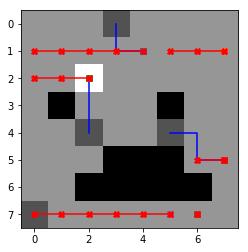

11 1.0 4 6


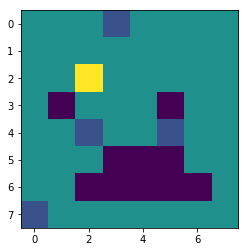

[array([1, 4], dtype=int64), array([1, 3], dtype=int64), array([1, 2], dtype=int64), array([1, 1], dtype=int64), array([1, 0], dtype=int64)]->End
[array([1, 7], dtype=int64), array([1, 6], dtype=int64), array([1, 5], dtype=int64)]->End
[array([2, 2], dtype=int64), array([2, 1], dtype=int64), array([2, 0], dtype=int64)]->End
[array([5, 7], dtype=int64), array([5, 6], dtype=int64)]->End
[array([7, 5], dtype=int64), array([7, 4], dtype=int64), array([7, 3], dtype=int64), array([7, 2], dtype=int64), array([7, 1], dtype=int64), array([7, 0], dtype=int64)]->End
[array([7, 6], dtype=int64)]->End


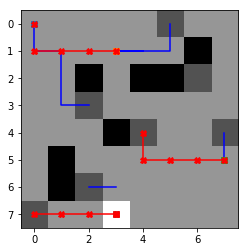

28 2.0 4 5


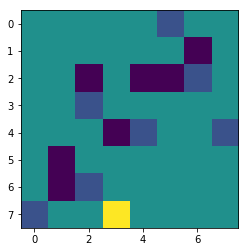

[array([0, 0], dtype=int64)]->End
[array([1, 3], dtype=int64), array([1, 2], dtype=int64), array([1, 1], dtype=int64), array([1, 0], dtype=int64)]->End
[array([5, 7], dtype=int64), array([5, 6], dtype=int64), array([5, 5], dtype=int64), array([5, 4], dtype=int64), array([4, 4], dtype=int64)]->End
[array([7, 3], dtype=int64), array([7, 2], dtype=int64), array([7, 1], dtype=int64), array([7, 0], dtype=int64)]->End


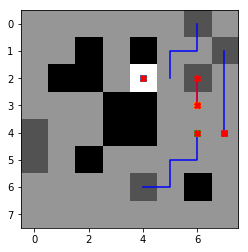

44 1.0 4 2


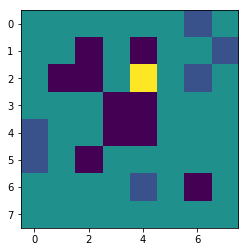

[array([2, 4], dtype=int64)]->End
[array([3, 6], dtype=int64), array([2, 6], dtype=int64)]->End
[array([4, 6], dtype=int64)]->End
[array([4, 7], dtype=int64)]->End


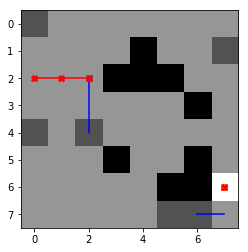

50 0.0 2 3


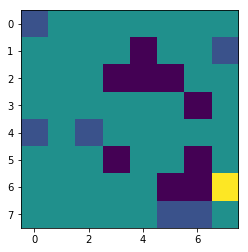

[array([2, 2], dtype=int64), array([2, 1], dtype=int64), array([2, 0], dtype=int64)]->End
[array([6, 7], dtype=int64)]->End
Goal_accuray: 0.2857142857142857
4.0 14.0
Average_Step_to_goal_in_each_domain : 4.0
16.0 4.0


In [47]:
correct, traj_step, total,total_env = 0.0,0.0,0.0,0.0

X,S,label = test_data[0].copy()

prev_env = X.clone()

whole_traj_act = []

Trajectory = [S]
Action  = [label]

go = np.where(X[1] == 1.0) 
goal = np.column_stack([go[0],go[1]])

end = len(test_data)


for i in range(1,80):
    X,S,label = test_data[i].copy()
    
    new_env = X.clone()
    
   
    if (new_env[0] - prev_env[0]).sum() == 0.0:

        if label != 4:
            Trajectory.append(S)
            Action.append(label)
        else:
            Trajectory.append(S)
            Action.append(label)
            whole_traj_act.append([Trajectory,Action])
            Trajectory = []
            Action = []
    else :
        #call the function with prev_new and whole traj act
        total_env += 1
        correct_goal,total_goal, traj_length,traj = agent_prediction(model,prev_env.clone(),whole_traj_act,goal,8,0)
        #correct_goal,total_goal, traj_length,traj = cooperative(model=model,X=prev_env.clone(),imsize=7)
        
        total += total_goal

        visualization(prev_env[0] - 0.5 * prev_env[1]+ abs(prev_env[2]),whole_traj_act,traj)
        print(i,correct_goal,total_goal,traj_length)
        plt.imshow(prev_env[0] - 0.5* prev_env[1] + abs(prev_env[2]))
        plt.show()
        for i in traj:
            print(i,end="->")
            print('End')
        correct += correct_goal
        traj_step += traj_length
        
        prev_env = new_env.clone()
        
        
        whole_traj_act = []
        go = np.where(prev_env[1] == 1.0) 
        goal = np.column_stack([go[0],go[1]])
        
        
print(f'Goal_accuray: {correct /total}')
print(correct,total)
print(f'Average_Step_to_goal_in_each_domain : {traj_step/total_env}')
print(traj_step,total_env)